# A tour of regression metrics

Author: [Thomas Moreau](https://tommoral.github.io/) and [Alexandre Gramfort](http://alexandre.gramfort.net)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

#  Evaluating the model quality


For supervised learning algorithms, where one wants to predict a target $y$ from a given input $X$, one needs to define a loss function. For a model $f_\theta$, parametrized by $\theta$, the goal of supervised learning can be written as
$$
    \min_{\theta \in \Theta} \frac{1}{N}\sum_{i=1}^N \ell[y_i, f_\theta(X_i))]
$$
for a well chosen loss function $\ell$ which measures the discrepancy between the predicted $f_\theta(X)$ and the true target $y$.

To **evaluate the model**, one needs to use a set of unseen data -- called *test set* or *validation set* -- to estimate the generalization performances of the model. This generalization can be quantified by computing the same loss used for training. However, these loss are not always very informative as there value can be hard to interpret (scale, imbalance, $\dots$).

To quantify the performance of a regression model different evaluation metrics are possible. We review below classical metric choices.

The simple way to use a scoring metric during cross-validation is via the scoring parameter of [`sklearn.model_selection.cross_validate`.](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate).
We will see now different metrics to evaluate the models.

See https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics for more details.

## Regression Metrics


### Mean Squared Error (MSE)

The most classical way to measure distance is to use the the $\ell_2$-norm. The MSE metric simply computes the average $\ell_2$-distance between the prediction and the true target, *i.e.*
$$
    MSE(y, \widehat y) = \frac{1}{N}\sum_{i=1}^N (y_i - \widehat y_i)^2
$$

While this metric can be useful to evaluate linear regression models with gaussian noise, it can fail to distinguish between good and bad cases when the assumptions of the linear model are broken. This is illustrated with the [Anscombe Quartet](https://fr.wikipedia.org/wiki/Quartet_d%27Anscombe), where 4 very different datasets have the same MSE error for linear regression. Note that as the `LinearRegression` fo scikit-learn is an Ordinary Least Squares, the reported MSE is the lowest one that can be achieved for a linear model.


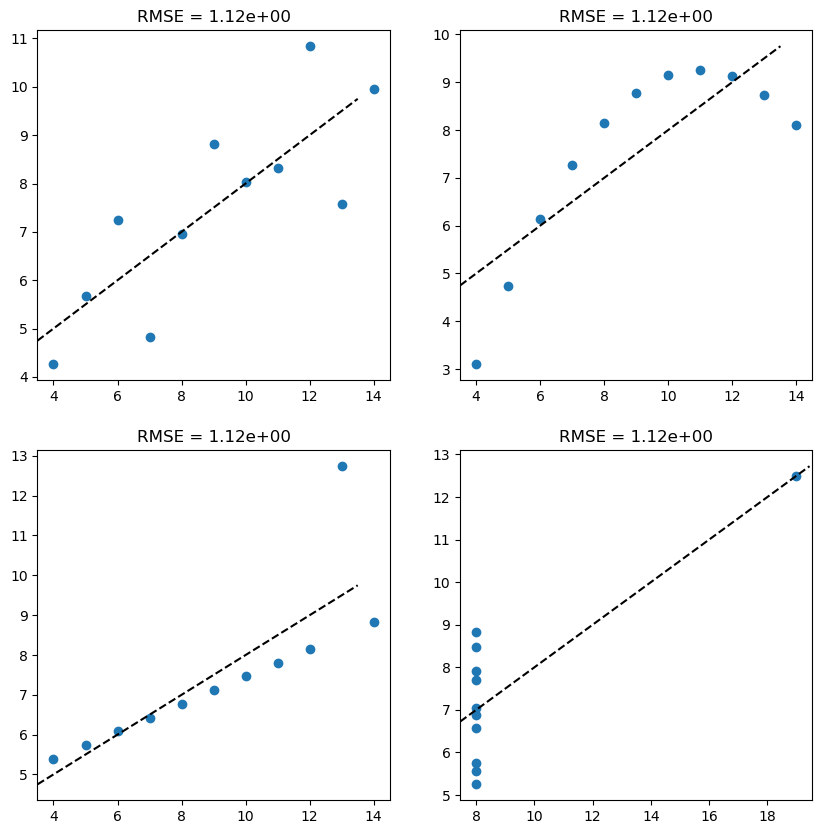

In [2]:
import json

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

with open('anscombe_quartet.json') as f:
    anscombe_quartet = np.array(json.load(f))
    
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for data, ax in zip(anscombe_quartet, axes.ravel()):
    x, y = data[0], data[1]
    reg.fit(x[:, None], y)
    y_pred = reg.predict(x[:, None])
    ax.scatter(x, y)
    
    xlim = ax.get_xlim()
    t = np.arange(*xlim)
    ax.plot(t, reg.coef_ * t + reg.intercept_, 'k--')
    ax.set_xlim(xlim)
    
    ax.set_title(f"RMSE = {np.sqrt(mean_squared_error(y_pred, y)):.2e}")

This metric can also be rescaled to take into account the variance of the original $y$. This is called the Explained Variance:
$$
    Var_{explained}(y, \widehat y) = \frac{\sum_{i=1}^N (y_i - \widehat y_i)^2
                                         }{\sum_{i=1}^N (y_i - \bar y)^2}
                                   = \frac{MSE(y, \widehat y)}{Var(y)}
    \enspace ,
$$
where $\bar y$ is the mean value of $y$. This value is also linked to the [Determination coefficient ($R^2$)](https://en.wikipedia.org/wiki/Coefficient_of_determination) as $R^2 = 1 - Var_{explained}$.

In [3]:
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]
# Shuffle the data
data, target = shuffle(data, target, random_state=0)

regressor = RandomForestRegressor(n_estimators=10)

print("R2 score:", cross_val_score(regressor, data, target, cv=5))

R2 score: [0.72262734 0.90887824 0.82809118 0.62904598 0.91528473]


R2 score is convenient because it has a natural scaling: 1 is
perfect prediction, and 0 is around chance

Now let us see which houses are easier to predict. Feature 3 tells us whether the house is along Charles river or not.

In [4]:
print("Along Charles River:",
      cross_val_score(regressor, data[data[:, 3] == 1],
                      target[data[:, 3] == 1], cv=5))
print("Not Along Charles River:",
      cross_val_score(regressor, data[data[:, 3] == 0],
                      target[data[:, 3] == 0], cv=5))

Along Charles River: [  0.45755554   0.42975667 -13.54918349   0.68785831   0.78955453]
Not Along Charles River: [0.7706308  0.88449938 0.90694732 0.80950251 0.90021505]


In [5]:
print("Along Charles River:",
      cross_val_score(regressor, data[data[:, 3] == 1],
                      target[data[:, 3] == 1], cv=5,
                      scoring='neg_mean_squared_error'))
print("Not Along Charles River:",
      cross_val_score(regressor, data[data[:, 3] == 0],
                      target[data[:, 3] == 0], cv=5,
                      scoring='neg_mean_squared_error'))

Along Charles River: [-108.67441429  -73.21085714  -95.15524286  -19.56352857  -33.34891429]
Not Along Charles River: [-15.97953895  -9.43512766  -8.0895883  -22.18325957  -6.93969574]


### Mean Absolute Error (MAE)

Another popular metric for regression is to use the $\ell_1$-norm to quantify the difference between the predictions and the target *i.e.*
$$
    MAE(y, \widehat y) = \frac{1}{N}\sum_{i=1}^N |y_i - \widehat y_i| \enspace .
$$
This metric is less sensitive to strong errors than the MSE, as it does not square the error:

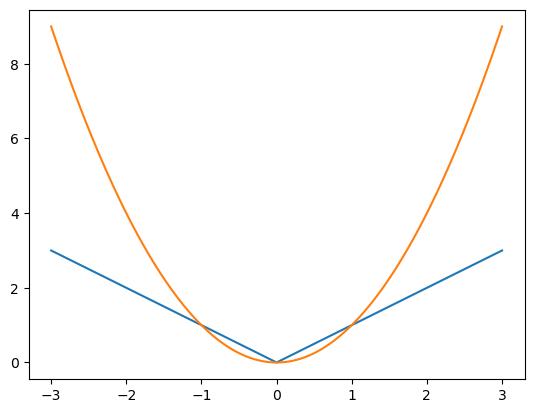

In [6]:
t = np.linspace(-3, 3, 1000)
plt.plot(t, abs(t))
plt.plot(t, t*t)

Let's use this MAE metric on the [Anscombe Quartet](https://fr.wikipedia.org/wiki/Quartet_d%27Anscombe)

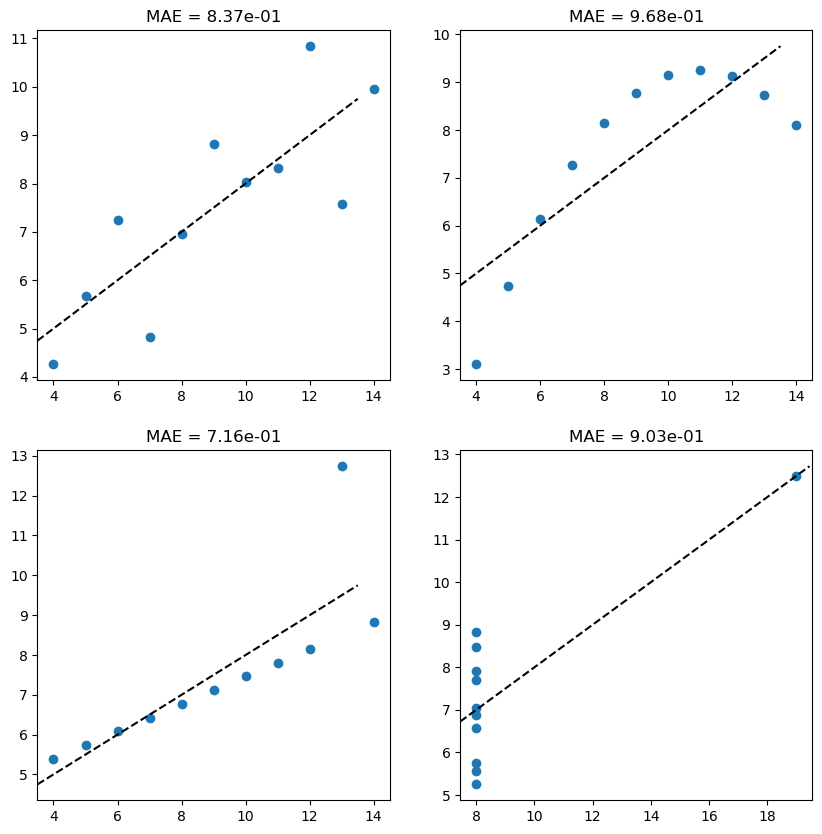

In [7]:
from sklearn.metrics import mean_absolute_error

reg = LinearRegression()
    
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for (x, y), ax in zip(anscombe_quartet, axes.ravel()):
    reg.fit(x[:, None], y)
    y_pred = reg.predict(x[:, None])
    ax.scatter(x, y)
    
    xlim = ax.get_xlim()
    t = np.arange(*xlim)
    ax.plot(t, reg.coef_ * t + reg.intercept_, 'k--')
    ax.set_xlim(xlim)
    ax.set_title(f"MAE = {mean_absolute_error(y_pred, y):.2e}")

In particular, the MAE metric is less sensitive to outliers.

Now let's see if we can find a regressor model that aims to optimize something closer
to the MAE. For this we will use the [HuberRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html)

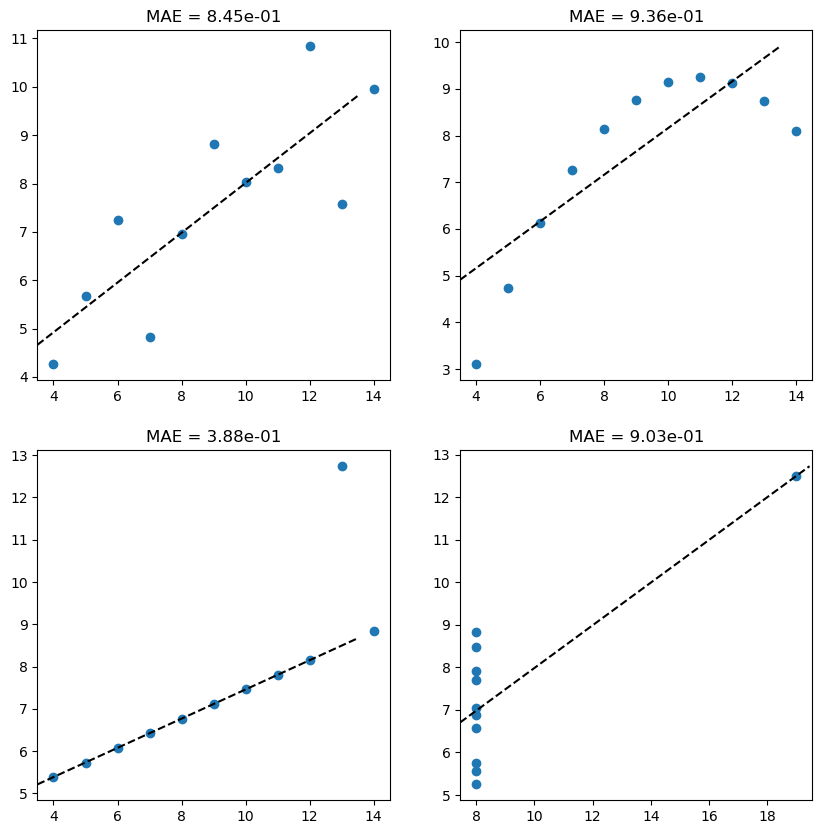

In [8]:
from sklearn.linear_model import HuberRegressor

reg = HuberRegressor()
    
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for (x, y), ax in zip(anscombe_quartet, axes.ravel()):
    reg.fit(x[:, None], y)
    y_pred = reg.predict(x[:, None])
    ax.scatter(x, y)
    
    xlim = ax.get_xlim()
    t = np.arange(*xlim)
    ax.plot(t, reg.coef_ * t + reg.intercept_, 'k--')
    ax.set_xlim(xlim)
    ax.set_title(f"MAE = {mean_absolute_error(y_pred, y):.2e}")

Another benefit from this metric is that it permits to report an error in the correct unit, meaningful for an application. Taking back the boston dataset:

In [9]:
data, target = shuffle(data, target, random_state=0)

print(cross_val_score(regressor, data, target, cv=5,
                      scoring='neg_mean_absolute_error'))

[-2.7654902  -2.22247525 -2.54316832 -2.28356436 -2.23792079]


### Scale free metrics

Depending on the application of the regression problem, it might be necessary to use a metric which quantifies the relative error instead of the absolute error. There exists various ways to define such a metric, in particular:

* The Mean Absolute Percentage Error (MAPE): $\displaystyle \frac{1}{N}\sum_{i=1}^N \left| \frac{y_i-\widehat y_i}{y_i}\right|~.$ This computes the error between the predicted value and the target, and rescales it compared to the value of the target $y$. This means that the same error of 1 won't have the same effect depending on the fact that $y=1$ or $y=1000$, which can be useful in various situation. It is [available in scikit-learn](https://scikit-learn.org/dev/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html) starting from version 0.24.

* The Mean Squared Log Error (MSLE): $\displaystyle \frac{1}{N}\sum_{i=1}^N (\log(1 + y_i) - \log(1 + \widehat y_i))^2$. This computes a risk metric corresponding to the expected value of the squared logarithmic (quadratic) error or loss. This metric is best to use when targets having exponential growth, such as population counts, average sales of a commodity over a span of years etc. Note that this metric penalizes an under-predicted estimate greater than an over-predicted estimate.